In [5]:
import numpy as np
import pandas as pd
import one_hot
import math


def SigmoidActivationFunction(weightedInput):
    return 1/(1 + np.exp(-weightedInput))

class Layer:
    def __init__(self,inputNodes,outputNodes) -> None:

        self.inputNodes = inputNodes
        self.outputNodes = outputNodes
        random = np.random.RandomState(1)
        """
        WEIGHTS
        tworzy 2-wymiarową listę z wartościami wag 
        Przykładowo gdy warstwa ma 2 wejścia i 3 wyjścia
        [w11   w21   w31]
        [w12   w22   w32]
        [w13   w23   w33]
        Z wartości pierwszej kolumny obliczana jest wartość wyjściowa dla 1 wyjścia
        Z wartości drugiej kolmny obliczana jest wartość wyjściowa 2 wyjścia
        BIAS_VALUES
        tworzy 1-wymiarową listę o wymiarze ilości wyjść dla warstwy
        Do wartości wyliczonej z popagacji do przodu do wyjścia dodawana jest wartość bias
        3 wyjścia
        [bias1 bias2 bias3]
        """
        self.weights = random.normal(loc=0.0, scale=0.1, size=(inputNodes, outputNodes))
        self.bias_values = np.zeros(outputNodes)
        self.costGradientW = np.zeros(shape = (inputNodes,outputNodes))

        self.costGradientB = np.zeros(shape = (outputNodes))


    """
    Gdy mamy doczynienia z pierwszą warstwą sieci 2 cechy wejścia i 2 klasy wyścia(layer(2,2))
    funkcja przelicza cechy*wagi i zwraca wartości wyjściowych neurownów 
    Gdy wsadzimy w funkcję listę [n_próbek, n_cech] to zwraca [n_próbek, n_neuronów_wyjściowych]
    dla 5 próbek i sieci (2,2) [5,2]
    X : tablica [n_próbek, n_cech]
    -> [n_próbek, n_outputNodes]
    """
    def forward_propagation(self,X): 
        output_values = np.dot(X,self.weights) + self.bias_values
        self.z = output_values
        activation_values = SigmoidActivationFunction(output_values)
        self.a = activation_values
        return activation_values

    """
    X: tablica [n_próbek,n_cech]
    -> tablica [n_próbek]
    """
    def predict(self,X):
        activation_values = self.forward_propagation(X)

        preditions = np.argmax(activation_values,axis=1)

        return preditions

    def NodeCost(self,outputActivation,expectedOutput):
        error = outputActivation - expectedOutput

        return 0.5*error*error
    
    def ApplyGradients(self,eta):

        self.bias_values -= self.costGradientB
        self.weights -= self.costGradientW * eta

class NeuralNetwork:
    def __init__(self,layerSizes,epoch,eta,minibatch_size) -> None:
        self.layers = [None]*(len(layerSizes)-1)
        for i in range(len(self.layers)):
            self.layers[i] = Layer(layerSizes[i],layerSizes[i+1])

        self.l2 = 0.
        self.epoch = epoch
        self.eta = eta
        self.errors = []
        self.minibatch_size = minibatch_size

    def network_forward_propagation(self,X):
        for layer in self.layers:
            X = layer.forward_propagation(X)

        return X

    def network_predict(self,X):
        activation_values = self.network_forward_propagation(X)

        predictions = np.argmax(activation_values,axis = 1)

        return predictions
    
    def network_loss(self,X,y):
        activation_values = self.network_forward_propagation(X)
        
        outputLayer = self.layers[len(self.layers)-1]
        total_cost = 0
        cost_single_data = 0

        for xi, target in zip(activation_values,y):
            for i in range(len(activation_values[0])):
                cost_single_data += outputLayer.NodeCost(xi[i],target[i]) 

            total_cost += cost_single_data
            cost_single_data = 0

        return total_cost / len(X)

    #def ApplyAllGradients(self):


    def learn(self,X,y):

        h = 0.0001
        y = one_hot._onehot(y,self.layers[len(self.layers)-1].outputNodes)
        
        originalCost = self.network_loss(X,y)
        for i in range(self.epoch):
            indices = np.arange(X.shape[0])
            np.random.RandomState(1).shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                for layer in self.layers:
                    for nodeIn in range(layer.inputNodes):
                        for nodeOut in range(layer.outputNodes):
                            layer.weights[nodeIn][nodeOut] +=h
                            deltaCost = self.network_loss(X,y) - originalCost
                            layer.weights[nodeIn][nodeOut] -=h
                            layer.costGradientW[nodeIn][nodeOut] = deltaCost/h


                    for biasIdx in range(layer.outputNodes):
                        layer.bias_values[biasIdx] +=h
                        deltaCost = self.network_loss(X,y) - originalCost
                        layer.bias_values[biasIdx] -=h
                        layer.costGradientB[biasIdx] = deltaCost/h
                    #print(layer.costGradientW.shape)
                    #print(layer.costGradientW)
                    #print(layer.costGradientB)
                    layer.ApplyGradients(self.eta)
                    originalCost = self.network_loss(X,y)

            self.errors.append(self.network_loss(X,y))

In [17]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

y1 =  df.iloc[0:150,4].values
y = np.where(y1[100:150] == 'Iris-virginica',2,0)
y2 = np.where(y1[50:100] == 'Iris-versicolor',1,0)
y3 = np.where(y1[0:50] == 'Iris-setosa',0,1)
y_final = np.append(y,y2)
Y = np.append(y_final,y3)
X = df.iloc[0:150,[0,2]].values
print(Y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [22]:
layers = [2,4,3]
network = NeuralNetwork(layers,10000,0.23,10)
network.learn(X,Y)

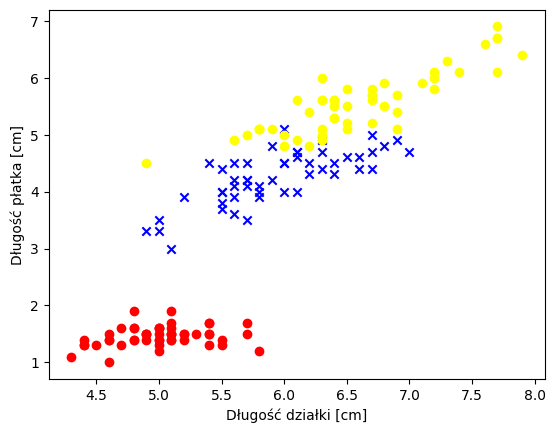

In [19]:
import matplotlib.pyplot as plt
plt.scatter(X[:50,0],X[:50,1],color = 'red', marker = 'o', label = 'Setosa')
plt.scatter(X[50:100,0],X[50:100,1],color = 'blue', marker = 'x', label = 'Versicolor')
plt.scatter(X[100:150,0],X[100:150,1],color = 'yellow', marker = 'o', label = 'Virginica')
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.show()

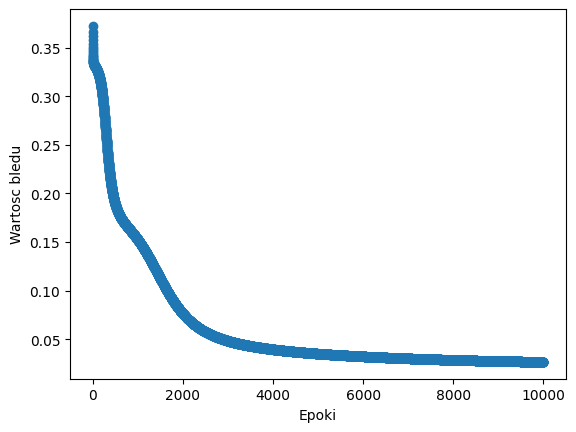

In [23]:
plt.plot(range(1,len(network.errors)+1),network.errors,marker = 'o')
plt.xlabel('Epoki')
plt.ylabel('Wartosc bledu')
plt.show()

In [10]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # konfiguruje generator znaczników i mapę kolorów
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # rysuje wykres powierzchni decyzyjnej
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.network_predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # rysuje wykres próbek
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

In [11]:
print(network.network_predict(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]


C:\Users\Adum\AppData\Local\Temp\ipykernel_5568\2377131987.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


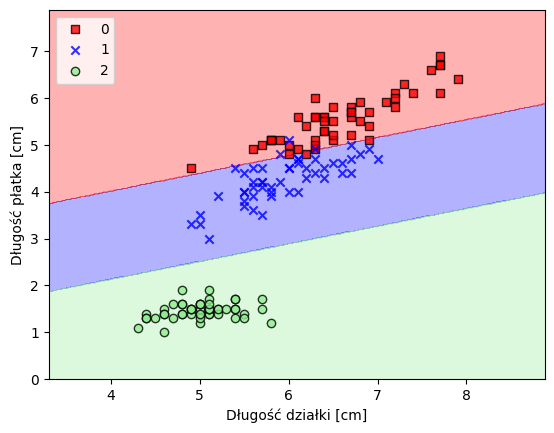

In [24]:
plot_decision_regions(X, Y, classifier=network)
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.legend(loc='upper left')


#plt.savefig('rysunki/02_08.png', dpi=300)
plt.show()